In [1]:
import sys
import os
from scipy.io import wavfile
import numpy as np
import theano
from theano import tensor as T
import lasagne
from lasagne.layers import *
from lasagne.init import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.updates import *
import cPickle as pickle
import matplotlib.pyplot as plt
%matplotlib inline

//anaconda/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
%load_ext rpy2.ipython

In [3]:
os.environ["DATA_DIR"] = "/Volumes/CB_RESEARCH/vocal_synthesis"

In [4]:
data_folder = os.environ["DATA_DIR"]
ctr = np.load(data_folder + os.path.sep + "x0.125_10_all_offset10_std.npy.sample.npz")
X_train, X_valid, X_test = ctr["arr_0"], ctr["arr_1"], ctr["arr_2"]    
X_train.shape, X_valid.shape, X_test.shape

((100, 80, 2000), (100, 80, 2000), (100, 80, 2000))

In [5]:
args = dict()
args["seed"] = 0
args["batch_size"] = 128
args["learning_rate"] = 0.01
args["momentum"] = 0.9
args["num_epochs"] = 4000
args["X_train"] = X_train
args["X_valid"] = X_train
args["X_test"] = X_train
args["update_method"] = rmsprop
args["units"] = [300]
args["forget_gate"] = 1.0

args["config"] = "../configurations/19mar_variable_3.py"

In [6]:
sys.path.append("..")
import rnn_experiment as exp
symbols = exp.prepare(args)
out_fn = symbols["out_fn"]
l_out = symbols["l_out"]
with open(data_folder + os.path.sep + "expensive_models" + os.path.sep + \
          "x0.125_10_all_offset10_std/19mar_300x1.model") as f:
    model = pickle.load(f)
set_all_param_values(l_out, model)

loading config: ../configurations/19mar_variable_3.py
test...
using forget gate init with value = 1Number of params in model: 3364700
<lasagne.layers.input.InputLayer object at 0x1129783d0>,(None, None, 2000)
<lasagne.layers.recurrent.LSTMLayer object at 0x1166d4cd0>,(None, None, 300)
<lasagne.layers.shape.ReshapeLayer object at 0x1166d4c90>,(None, 300)
<lasagne.layers.dense.DenseLayer object at 0x1047d0390>,(None, 2000)
<lasagne.layers.shape.ReshapeLayer object at 0x120036850>,(None, None, 2000)


Generate some sequences from the first sequence of the train set, valid set, and test set

In [16]:
how_long = 200
arr = []
for X_query in [X_train, X_valid, X_test]:
    generated_seq = X_query[0:1].flatten().tolist()
    generated_seq_array = []
    # x1, x2, ..., x40
    for i in range(0, X_query.shape[1]):
        generated_seq_array.append(X_query[0:1, i, :][0])
    ctr = 0
    for x in range(0, how_long):
        #this_input = np.asarray(generated_seq_array[ctr::])
        this_input = np.asarray(generated_seq_array)
        this_input = this_input.reshape( (1, this_input.shape[0], this_input.shape[1]))
        this_out = out_fn(this_input)[0][-1]
        assert this_out.shape == (2000,)
        generated_seq_array.append(this_out)
        ctr += 1
    generated_seq_array = generated_seq_array[ X_query.shape[1] :: ]
    arr.append( generated_seq_array )

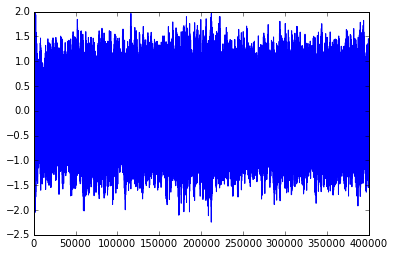

In [17]:
# generated seq from train set
generated_seq_train = np.asarray(arr[0]).flatten()
plt.plot(generated_seq_train)

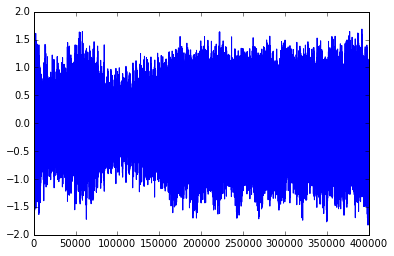

In [18]:
# generated seq from valid set
generated_seq_valid = np.asarray(arr[1]).flatten()
plt.plot(generated_seq_valid)

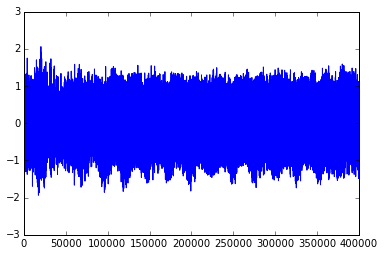

In [19]:
# generated seq from valid set
generated_seq_test = np.asarray(arr[2]).flatten()
plt.plot(generated_seq_test)

----

In [13]:
fs, data = wavfile.read(data_folder + os.path.sep + "data.wav")
print data.dtype
data = np.asarray(data, dtype="float32")
min_, max_, mean_ = np.min(data), np.max(data), np.mean(data)

int16


In [14]:
std_ = np.std(data)

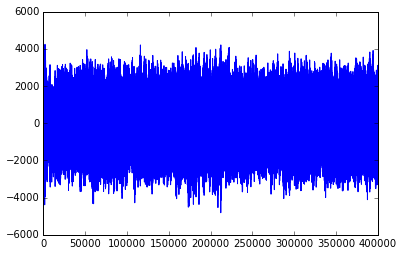

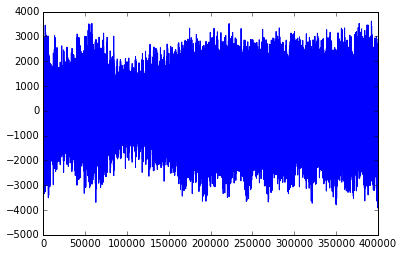

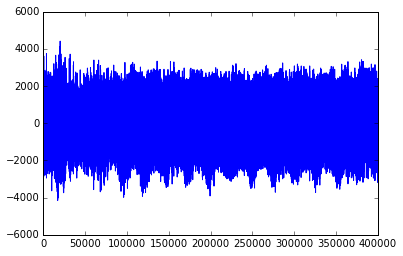

In [20]:
for tp in [(generated_seq_train, "train"), (generated_seq_valid, "valid"), (generated_seq_test, "test")]:
    tmp = np.asarray(tp[0])
    tmp = tmp * std_
    tmp = np.asarray(tmp, dtype="int16")
    out_file = "/tmp/29mar2_generated_%s.wav" % tp[1]
    wavfile.write(filename=out_file, rate=fs, data=tmp)
    plt.plot(tmp)
    plt.show()
    plt.close()

----

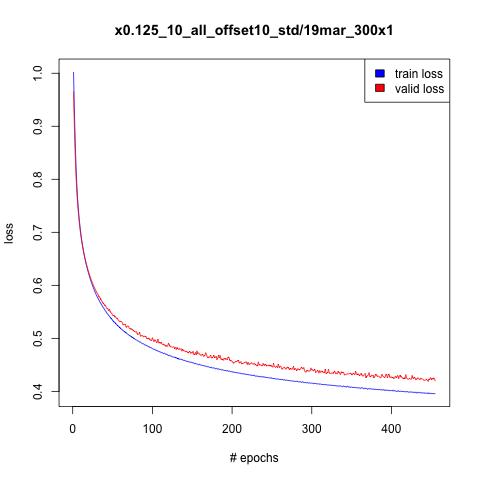

In [7]:
%%R
df = read.csv("../models/x0.125_10_all_offset10_std/19mar_300x1.txt")

plot(df$train_loss, type="l", xlab="# epochs", ylab="loss", col="blue", main="x0.125_10_all_offset10_std/19mar_300x1",
    ylim=c(  min( min(df$train_loss), min(df$valid_loss) ) , max( max(df$train_loss), max(df$valid_loss) )  ))
lines(df$valid_loss, type="l", col="red")
legend("topright", legend=c("train loss", "valid loss"), fill=c("blue", "red"))